Analyzing serial vs shuffle, add vs mul gates. Later on in thee note book. Analyze types of multi, and also learned gates. 

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange

# Factorized experiments

In [2]:
experiments = [ 'shuffle_add', 'shuffle_mul', 'random_gates_add', 'random_gates_mul',]
folder_name = './../files/controls/'


In [3]:
def get_log_files(data_folder, exp_name, file_sig='testing_log', search_strs=[]):
    lfiles = os.listdir(data_folder+f'{exp_name}/')
    lfiles = [fn for fn in lfiles if fn.__contains__(file_sig)]
    for sstr in search_strs:
        lfiles = [fn for fn in lfiles if fn.__contains__(sstr)]

    logs = []
    for fi, fn in enumerate(lfiles):
        try:
            logs.append(np.load(data_folder+f'{exp_name}/' + fn, allow_pickle=True).item())
        except:
            print('some problem with ', fn)
    return(logs, lfiles)

In [4]:
exps = experiments
accuracy_dict = {}
total_trials_dict={}
average_acc_dict = {}
for exp_name in exps:
    logs, lfiles = get_log_files(folder_name, exp_name, file_sig='testing_log', search_strs=['tasks_14_'])
    mean_accuracies = []
    totals = []
    average_acc =[]
    for log in logs:
        final_accuracy_average = np.mean(list(log.accuracies[-1].values()))
        mean_accuracies.append(final_accuracy_average)
        totals.append(log.total_batches)
        
        # avg
        taa = []
        for logi in range(15):
            taa.append([test_acc[logi] for test_acc in log.accuracies])
        average_acc.append(np.stack(taa))
        
    accuracy_dict.update({exp_name: np.stack(mean_accuracies)})
    total_trials_dict.update({exp_name: np.stack(totals)})
    average_acc_dict.update({exp_name: (average_acc)})

Text(0, 0.5, 'End avg accuracy')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


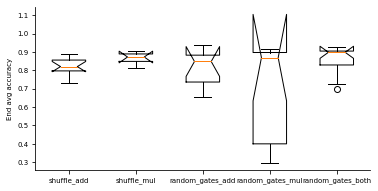

In [5]:
exps_names=  experiments

fig, (ax) = plt.subplots(1,1, figsize=[6,3])
_=ax.boxplot([accuracy_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('End avg accuracy')
# plt.savefig('end_accuracy_box_plots.jpg',dpi=300)

(0.0, 5000.0)

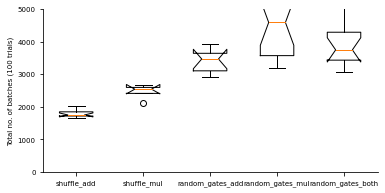

In [6]:
fig, (ax) = plt.subplots(1,1, figsize=[6,3])
_=ax.boxplot([total_trials_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Total no. of batches (100 trials)')
ax.set_ylim([0, 5000])
# plt.savefig('./files/total_batches_box_plots.jpg',dpi=300)

average_acc_dict is a dict of keys experiment name. Returns a list of np arrays with accuracies from all tasks. Still need to average them [no_tasks, tstamps]


In [ ]:
def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))


In [ ]:
logs, lifiles = get_log_files(folder_name, 'shuffle_add', file_sig='training_log',  search_strs=['tasks_10'])
def new_get_rehearsals(logs, rehearsal_no=1):

    # print('swtch \ttid \t rehNo \t ttc \t order')
    rehearsal_ttcs = []
    for log in logs:
        times_seen = []
        order_learned = []
        ttc = []
        np_task_id = np.array(log.switch_task_id)
        np_stamps = log.switch_trialxxbatch + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch)):
            times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
            order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
    # for i in (range(12)):
        # print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    return( np.stack(rehearsal_ttcs) )

rt = new_get_rehearsals(logs, 1)

In [ ]:
log = logs[0]
T = len(log.switch_trialxxbatch)
first_serial_block= (np.array(logs[0].trials_to_crit)> 1).argmax()
# first_serial_block= T - 8
print ('switch_trial\t task_id\t ttc\t first')
for ti in range(T-10, T):
    print (f'{log.switch_trialxxbatch[ti]}\t\t {log.switch_task_id[ti]}\t\t {log.trials_to_crit[ti]}\t', f'{1 if (first_serial_block==ti) else 0}')

switch_trial	 task_id	 ttc	 first
1298		 6		 1	 0
1299		 3		 1	 0
1299		 10		 22	 1
1321		 11		 14	 0
1335		 10		 12	 0
1347		 11		 11	 0
1358		 12		 28	 0
1386		 10		 11	 0
1397		 11		 12	 0
1409		 12		 12	 0


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


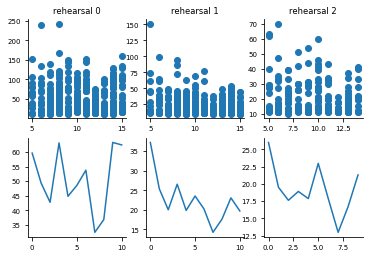

In [4]:
exp_name = 'shuffle_add'
rehearsal_ttcs = []
global_times_seen = []
order_learned = []
ttc = []
for no_tasks in range(4,14):
    logs, lifiles = get_log_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    # print('swtch \ttid \t rehNo \t ttc \t order')
    for log in logs:
        times_seen = []
        first_serial_block= (np.array(log.trials_to_crit)> 1).argmax()
        np_task_id = np.array(log.switch_task_id[first_serial_block:])
        np_stamps = log.switch_trialxxbatch[first_serial_block:] + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch[first_serial_block:])):
            times_seen.append( np.sum( np_task_id[:i]== np_task_id[i]))
            order_learned.append(no_tasks+ np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        # rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
        global_times_seen += times_seen
rehearsal_no = 0
fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
fig, axes = plt.subplots(2,3)

for i in range(3):
    ax = axes[0,i]
    rehearsal_no = i
    fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
    forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
    ax.scatter(forder_learned, fttc)
    ax.set_title(f'rehearsal {rehearsal_no}')

    ax = axes[1,i]
    ax.plot([np.mean(np.array(fttc)[np.array(forder_learned) == ol]) for ol in np.unique(forder_learned)])


#### Speared focused analysis of first learning

-8 new task  
-7 another new task2  
-6 1st rehearsal 
-5 task2 reh (1st rehearsal) 
-4 task3
-3 2nd rehearsal 
-2 task2 2nd rehearsal (2nd rehearsal) 

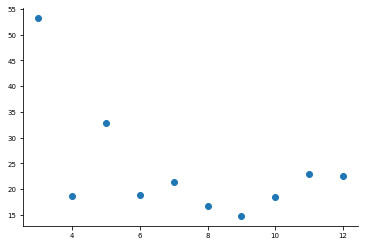

In [5]:
ttc_pick = -1
exp_name = 'shuffle_add'
order_learned = []
ttc = []
for no_tasks in range(3,13):
    logs, lifiles = get_log_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    # print('swtch \ttid \t rehNo \t ttc \t order')
    ttc_task_1 = []
    for log in logs:
        ttc_task_1.append(log.trials_to_crit[ttc_pick]) # This is the the first task learned.
    ttc.append(ttc_task_1)
    order_learned.append(no_tasks)

# fig, axes = plt.subplots(2,3)

plt.scatter(order_learned, [np.mean(tt) for tt in ttc])



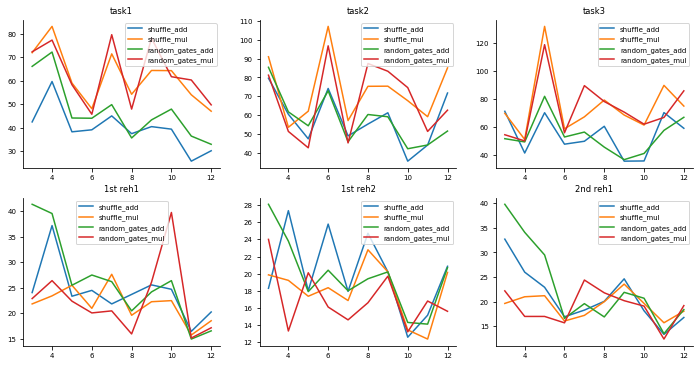

In [12]:
def focused_ttc(exp_name, ttc_pick=-8):
    order_learned = []
    ttc = []
    for no_tasks in range(3,13):
        logs, lifiles = get_log_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
        # print('swtch \ttid \t rehNo \t ttc \t order')
        ttc_task_1 = []
        for log in logs:
            ttc_task_1.append(log.trials_to_crit[ttc_pick]) # This is the the first task learned.
        ttc.append(ttc_task_1)
        order_learned.append(no_tasks)
    return (order_learned, ttc) # order learned is simple range(3,13), ttc is ttc data grouped by no_tasks [no_tasks, runs]

fig, axes = plt.subplots(2,3, figsize =[12,6])
axi=0
names = ['task1','task2', 'task3', '1st reh1', '1st reh2','2nd reh1']
for ttc_pick in [-8,-7, -4, -6, -5,-3]:
    for en in (experiments):
        order_learned, ttc = focused_ttc(exp_name =en, ttc_pick= ttc_pick)
        ax = axes.flatten()[axi]
        ax.set_title(names[axi])
        ax.plot(order_learned, [np.mean(tt) for tt in ttc], label=en)
        # _=plt.boxplot( ttc)
    ax.legend()
    axi += 1

plt.savefig('./files/spear_focused_analysis.jpg', dpi=300)


SO now I have three arrays:
times_seen
order_learned
ttc

I need to filter ttc based on times_seen: no of rehearsal interested in, really 0, 1, 2
and bin them by order_learned from 3 - 14





In [39]:
exp_name = 'random_gates_mul'
rehearsal_ttcs = []

global_times_seen = []
order_learned = []
ttc = []
    
for no_tasks in range(4,13):
    logs, lifiles = get_log_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    
    # print('swtch \ttid \t rehNo \t ttc \t order')
    for log in logs:
        times_seen = []
        first_serial_block= max( len(log.trials_to_crit)-8 , (np.array(log.trials_to_crit)> 1).argmax())
        np_task_id = np.array(log.switch_task_id[first_serial_block:])
        np_stamps = log.switch_trialxxbatch[first_serial_block:] + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch[first_serial_block:])):
            times_seen.append( np.sum( np_task_id[:i]== np_task_id[i]))
            order_learned.append(no_tasks+ np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        # rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
        global_times_seen += times_seen
    for i in (range(8)):
        print(np_stamps[i], '\t', np_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    # return( np.stack(rehearsal_ttcs) )

# rt = new_get_rehearsals(logs, 1)

485 	 11 	 0 	 11 	 5
498 	 9 	 0 	 11 	 6
515 	 14 	 0 	 24 	 7
574 	 2 	 0 	 72 	 8
609 	 11 	 1 	 11 	 5
621 	 9 	 1 	 11 	 6
687 	 14 	 1 	 13 	 7
712 	 2 	 1 	 24 	 8
704 	 14 	 0 	 11 	 5
717 	 2 	 0 	 11 	 6
729 	 13 	 0 	 24 	 7
931 	 11 	 0 	 72 	 8
951 	 9 	 0 	 11 	 5
1029 	 14 	 1 	 11 	 6
1094 	 2 	 1 	 13 	 7
1148 	 13 	 1 	 24 	 8
953 	 13 	 0 	 11 	 5
965 	 0 	 0 	 11 	 6
990 	 11 	 0 	 24 	 7
1002 	 9 	 0 	 72 	 8
1020 	 14 	 0 	 11 	 5
1037 	 2 	 0 	 11 	 6
1063 	 13 	 1 	 13 	 7
1075 	 0 	 1 	 24 	 8
979 	 10 	 0 	 11 	 5
999 	 11 	 0 	 11 	 6
1010 	 9 	 0 	 24 	 7
1033 	 14 	 0 	 72 	 8
1045 	 2 	 0 	 11 	 5
1057 	 13 	 0 	 11 	 6
1069 	 0 	 0 	 13 	 7
1080 	 10 	 1 	 24 	 8
1439 	 11 	 0 	 11 	 5
1451 	 9 	 0 	 11 	 6
1477 	 14 	 0 	 24 	 7
1489 	 2 	 0 	 72 	 8
1530 	 13 	 0 	 11 	 5
1545 	 0 	 0 	 11 	 6
1556 	 10 	 0 	 13 	 7
1569 	 1 	 0 	 24 	 8
1377 	 9 	 0 	 11 	 5
1401 	 14 	 0 	 11 	 6
1412 	 2 	 0 	 24 	 7
1424 	 13 	 0 	 72 	 8
1437 	 0 	 0 	 11 	 5
1448

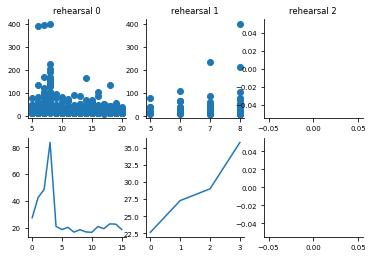

In [36]:
fig, axes = plt.subplots(2,3)
for i in range(3):
    ax = axes[0,i]
    rehearsal_no = i
    fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
    forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
    ax.scatter(forder_learned, fttc)
    ax.set_title(f'rehearsal {rehearsal_no}')

    ax = axes[1,i]
    ax.plot([np.mean(np.array(fttc)[np.array(forder_learned) == ol]) for ol in np.unique(forder_learned)])


In [ ]:
logs, lifiles = get_log_files(folder_name, 'shuffle_add', file_sig='training_log',  search_strs=['tasks_10'])
def new_get_rehearsals(logs, rehearsal_no=1):

    # print('swtch \ttid \t rehNo \t ttc \t order')
    rehearsal_ttcs = []
    for log in logs:
        times_seen = []
        order_learned = []
        ttc = []
        np_task_id = np.array(log.switch_task_id)
        np_stamps = log.switch_trialxxbatch + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch)):
            times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
            order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
    # for i in (range(12)):
        # print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    return( np.stack(rehearsal_ttcs) )

rt = new_get_rehearsals(logs, 1
)

# Learned gates. Also variety of multi gates

In [2]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange

In [3]:
experiments = [  'random_gates_mul',]
folder_name = './../files/gates_mul_titrate_scale/'


In [5]:
def get_log_files(data_folder, exp_name, file_sig='testing_log', search_strs=[]):
    lfiles = os.listdir(data_folder+f'{exp_name}/')
    lfiles = [fn for fn in lfiles if fn.__contains__(file_sig)]
    for sstr in search_strs:
        lfiles = [fn for fn in lfiles if fn.__contains__(sstr)]

    logs = []
    for fi, fn in enumerate(lfiles):
        try:
            logs.append(np.load(data_folder+f'{exp_name}/' + fn, allow_pickle=True).item())
        except:
            print('some problem with ', fn)
    return(logs, lfiles)

In [5]:
# search space
gates_means = [(x/10) for x in range(5,15, 2)]
gates_means.insert(3, 1.0) # gates_mean  Just added 10,
print(gates_means) 
gates_stds = [(x/10) for x in range(0,3, 1)] #gates_std  
gates_sparsities = [(x/10) for x in [3, 4,5,6,]] # 0 and 9 are also available gates_sparsity 
no_of_tasks = 14

## adding more nuance


signatures = [f'{gm:1.1f}_{gs:1.1f}_{gsp:1.1f}_' for gm in gates_means for gs in gates_stds for gsp in gates_sparsities]




[0.5, 0.7, 0.9, 1.0, 1.1, 1.3]


In [6]:
exps = experiments
train_total_batchs_dict= {}
test_train_total_batchs_dict= {}
train_end_accs_dict = {}
test_train_end_accs_dict = {}
novel_task_ttcs_dict = {}
old_tasks_ttcs_dict = {}
drop_accs_dict = {}

for exp_name in exps:
    for sig in signatures:
        logs, lfiles = get_log_files(folder_name, exp_name, file_sig='testing_log', search_strs=[f'tasks_{no_of_tasks}_', sig])
        train_logs, lfiles = get_log_files(folder_name, exp_name, file_sig='training_log', search_strs=[f'tasks_{no_of_tasks}_', sig])
        config_logs, config_files = get_log_files(folder_name, exp_name, file_sig='config', search_strs=[f'tasks_{no_of_tasks}_', sig])
        if (len(logs)> 0):
            train_total_batchs= []
            test_train_total_batchs= []
            train_end_accs = []
            test_train_end_accs = []
            novel_task_ttcs = []
            old_tasks_ttcs = []
            drop_accs = []

            for log, train_log in zip(logs, train_logs):
                train_total_batchs.append(log.start_testing_at)
                test_train_total_batchs.append(log.stamps[-1] - log.start_testing_at)

                end_train = np.argmax(np.array(log.stamps) > log.start_testing_at) # find the closest testing point to start testing step_i
                
                train_end_accs.append(np.mean(list(log.accuracies[end_train].values())))
                test_train_end_accs.append(np.mean(list(log.accuracies[-1].values())))

                novel_task_ttcs.append(train_log.trials_to_crit[-no_of_tasks-1])
                old_tasks_ttcs.append (train_log.trials_to_crit[-no_of_tasks:])
                drop_accs.append( train_end_accs[-1] - np.mean(list(log.accuracies[end_train+novel_task_ttcs[-1]].values())) )# compare avg_acc end of train to end of training novel task
        
                
            # train_total_batchs_dict.update({exp_name+sig: np.stack(train_total_batchs)})
            # test_train_total_batchs_dict.update({exp_name+sig: np.stack(test_train_total_batchs)})
            # train_end_accs_dict .update({exp_name+sig: np.stack(train_end_accs)})
            # test_train_end_accs_dict .update({exp_name+sig: np.stack(test_train_end_accs)})
            # novel_task_ttcs_dict .update({exp_name+sig: np.stack(novel_task_ttcs)})
            # old_tasks_ttcs_dict .update({exp_name+sig: np.stack(old_tasks_ttcs)})
            # drop_accs_dict .update({exp_name+sig: np.stack(drop_accs)})

            train_total_batchs_dict.update({exp_name+sig:   np.stack(train_total_batchs).mean()})
            test_train_total_batchs_dict.update({exp_name+sig: np.stack(test_train_total_batchs).mean()})
            train_end_accs_dict .update({exp_name+sig: np.stack(train_end_accs).mean()})
            test_train_end_accs_dict .update({exp_name+sig: np.stack(test_train_end_accs).mean()})
            novel_task_ttcs_dict .update({exp_name+sig: np.stack(novel_task_ttcs).mean()})
            old_tasks_ttcs_dict .update({exp_name+sig: np.stack(old_tasks_ttcs).mean()})
            drop_accs_dict .update({exp_name+sig: np.stack(drop_accs).mean()})


In [7]:
config_logs, config_files = get_log_files(folder_name, exp_name, file_sig='config', search_strs=[f'tasks_{no_of_tasks}_', signatures[3]])

In [8]:
len(train_total_batchs_dict.keys())

72

In [9]:
def get_min(test_dict):
    temp = min(test_dict.values())
    res = [key for key in test_dict if test_dict[key] == temp]
    return (res)
print(get_min(train_total_batchs_dict))

['random_gates_mul0.7_0.0_0.4_']


In [6]:
def get_values(dic_of_interest = train_total_batchs_dict):
    values = np.empty([len(gates_means), len(gates_stds), len(gates_sparsities), ])
    for m in range(len(gates_means)):
        for st in range(len(gates_stds)):
            for sp in range(len(gates_sparsities)):
                try:
                    values[m,st,sp] = dic_of_interest[exp_name+f'{gates_means[m]}_{gates_stds[st]}_{gates_sparsities[sp]}_']
                except KeyError:
                    values[m,st,sp] = np.nan
    return(values)
values= get_values(dic_of_interest = train_total_batchs_dict)

In [11]:
values = get_values(dic_of_interest=test_train_end_accs_dict)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


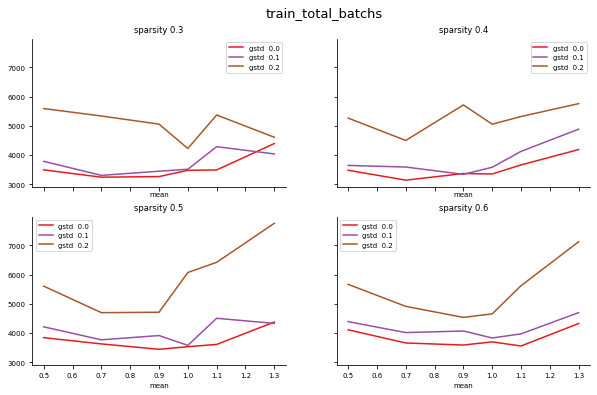

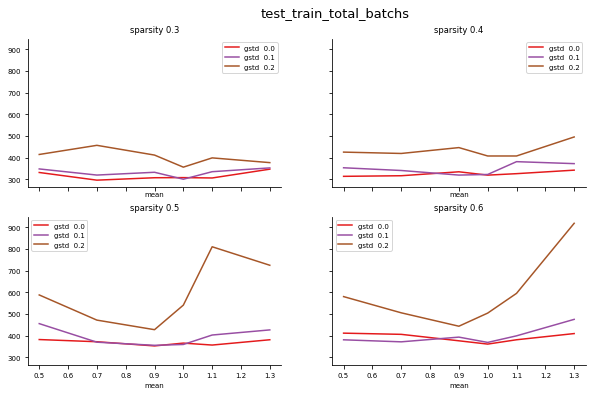

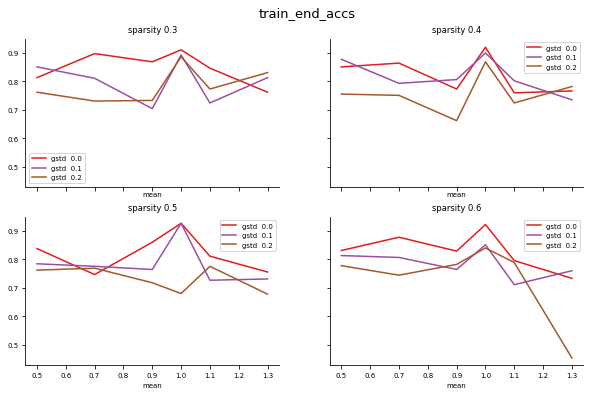

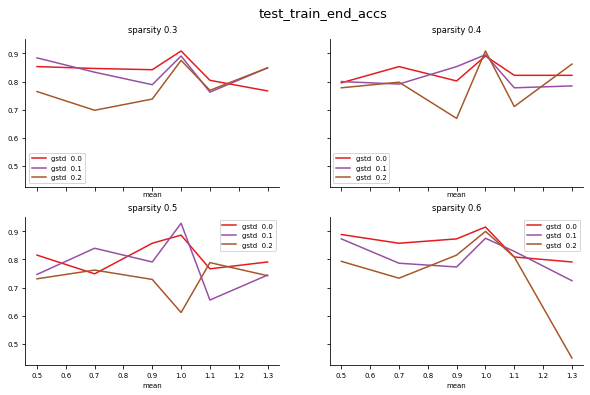

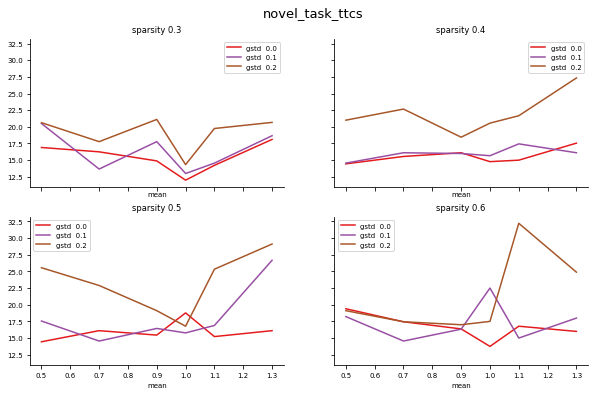

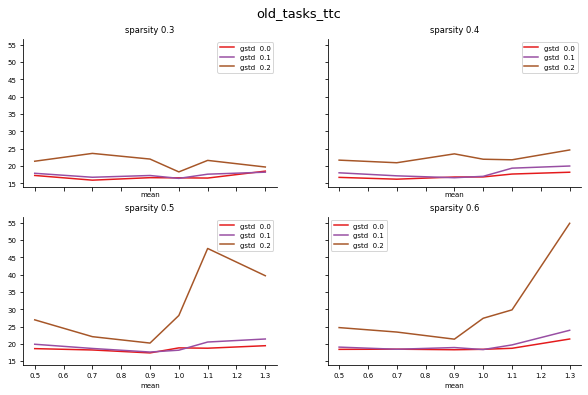

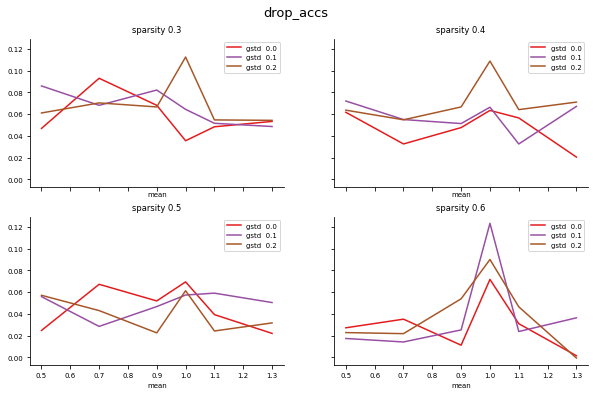

In [12]:
# Define Dataset
dics = {'train_total_batchs': train_total_batchs_dict,
'test_train_total_batchs': test_train_total_batchs_dict,
'train_end_accs': train_end_accs_dict ,
"test_train_end_accs": test_train_end_accs_dict ,
'novel_task_ttcs': novel_task_ttcs_dict ,
'old_tasks_ttc': old_tasks_ttcs_dict,
'drop_accs': drop_accs_dict}

x,y,z = gates_means, gates_stds, gates_sparsities

# Creating figure
for dic in dics:
    values =get_values(dics[dic])
    # ax = plt.axes(projection ="3d")
    color_map = plt.get_cmap('Set2')
    no_of_values = len(gates_stds)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)


    fig, axes= plt.subplots(2,2, figsize = (10, 6), sharey=True, sharex=True)
    for sp in range(len(gates_sparsities)):
        ax = axes.flatten()[sp]
        for st in range(len(gates_stds)):
            ax.plot(gates_means, [values[m,st,sp] for m in range(len(gates_means))], label=f'gstd  {gates_stds[st]}', c=cmap.to_rgba(st),)
            ax.set_xlabel(f'mean')
            ax.set_title(f'sparsity {gates_sparsities[sp]}')
        ax.legend()
    axes[0,0].text(0.92, 1.15, dic, fontsize=13, transform=axes[0,0].transAxes)

    plt.savefig(f'./files/perf_{dic}.jpg', dpi=300)

3

In [55]:
experiments = [ 'shuffle_add', 'shuffle_mul', 'random_gates_add', 'random_gates_mul', 'random_gates_both']
# folder_name = './../files/gates_compare_learn/'
folder_name = './../files/gates_compare/'

# search space
gates_means = [(x/10) for x in [10]]
# gates_means.insert(3, 1.0) # gates_mean  Just added 10,
print(gates_means) 
gates_stds = [(x/10) for x in range(0,1, 1)] #gates_std  
# gates_sparsities = [(x/10) for x in range(0,6, 4)] # 0 and 9 are also available gates_sparsity 
gates_sparsities = [(x/10) for x in [4]] # 0 and 9 are also available gates_sparsity 
no_of_tasks = 14

## adding more nuance


signatures = [f'{gm:1.1f}_{gs:1.1f}_{gsp:1.1f}_' for gm in gates_means for gs in gates_stds for gsp in gates_sparsities]




[1.0]


In [56]:
signatures

['1.0_0.0_0.4_']

In [57]:
exps = experiments
accuracy_dict = {}
total_trials_dict={}
average_acc_dict = {}
for exp_name in exps:
    logs, lfiles = get_log_files(folder_name, exp_name, file_sig='testing_log', search_strs=['tasks_14_'])
    mean_accuracies = []
    totals = []
    average_acc =[]
    for log in logs:
        final_accuracy_average = np.mean(list(log.accuracies[-1].values()))
        mean_accuracies.append(final_accuracy_average)
        totals.append(log.total_batches)
        
        # avg
        taa = []
        for logi in range(15):
            taa.append([test_acc[logi] for test_acc in log.accuracies])
        average_acc.append(np.stack(taa))
        
    accuracy_dict.update({exp_name: np.stack(mean_accuracies)})
    total_trials_dict.update({exp_name: np.stack(totals)})
    average_acc_dict.update({exp_name: (average_acc)})

In [63]:
exps = experiments
train_total_batchs_dict= {}
test_train_total_batchs_dict= {}
train_end_accs_dict = {}
test_train_end_accs_dict = {}
novel_task_ttcs_dict = {}
old_tasks_ttcs_dict = {}
drop_accs_dict = {}

for exp_name in exps:
    for sig in signatures:
        logs, lfiles = get_log_files(folder_name, exp_name, file_sig='testing_log', search_strs=[f'tasks_{no_of_tasks}_', sig])
        train_logs, lfiles = get_log_files(folder_name, exp_name, file_sig='training_log', search_strs=[f'tasks_{no_of_tasks}_', sig])
        config_logs, config_files = get_log_files(folder_name, exp_name, file_sig='config', search_strs=[f'tasks_{no_of_tasks}_', sig])
        if (len(logs)> 0):
            train_total_batchs= []
            test_train_total_batchs= []
            train_end_accs = []
            test_train_end_accs = []
            novel_task_ttcs = []
            old_tasks_ttcs = []
            drop_accs = []

            for log, train_log in zip(logs, train_logs):
                train_total_batchs.append(log.start_testing_at)
                test_train_total_batchs.append(log.stamps[-1] - log.start_testing_at)

                end_train = np.argmax(np.array(log.stamps) > log.start_testing_at) # find the closest testing point to start testing step_i
                
                train_end_accs.append(np.mean(list(log.accuracies[end_train].values())))
                test_train_end_accs.append(np.mean(list(log.accuracies[-1].values())))

                novel_task_ttcs.append(train_log.trials_to_crit[-no_of_tasks-1])
                old_tasks_ttcs.append (train_log.trials_to_crit[-no_of_tasks:])
                drop_accs.append( train_end_accs[-1] - np.mean(list(log.accuracies[end_train+novel_task_ttcs[-1]].values())) )# compare avg_acc end of train to end of training novel task
        
                
            train_total_batchs_dict.update({exp_name+sig: np.stack(train_total_batchs)})
            test_train_total_batchs_dict.update({exp_name+sig: np.stack(test_train_total_batchs)})
            train_end_accs_dict .update({exp_name+sig: np.stack(train_end_accs)})
            test_train_end_accs_dict .update({exp_name+sig: np.stack(test_train_end_accs)})
            novel_task_ttcs_dict .update({exp_name+sig: np.stack(novel_task_ttcs)})
            old_tasks_ttcs_dict .update({exp_name+sig: np.stack(old_tasks_ttcs).mean(-1)})
            drop_accs_dict .update({exp_name+sig: np.stack(drop_accs)})


In [59]:
[exp for exp in dics[dic].keys()]

['shuffle_add1.0_0.0_0.4_',
 'shuffle_mul1.0_0.0_0.4_',
 'random_gates_add1.0_0.0_0.4_',
 'random_gates_mul1.0_0.0_0.4_',
 'random_gates_both1.0_0.0_0.4_']

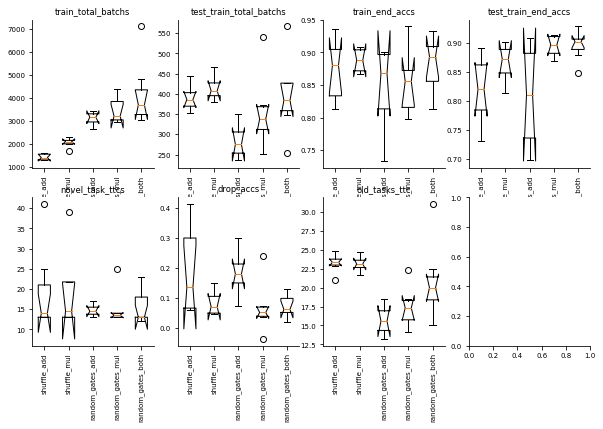

In [64]:
# Define Dataset
dics = {'train_total_batchs': train_total_batchs_dict,
'test_train_total_batchs': test_train_total_batchs_dict,
'train_end_accs': train_end_accs_dict ,
"test_train_end_accs": test_train_end_accs_dict ,
'novel_task_ttcs': novel_task_ttcs_dict ,
'drop_accs': drop_accs_dict,
'old_tasks_ttc': old_tasks_ttcs_dict,}

x,y,z = gates_means, gates_stds, gates_sparsities

# Creating figure
fig, axes= plt.subplots(2,4, figsize = (10, 6))
for di, dic in enumerate(dics):
    # values =get_values(dics[dic])
    # ax = plt.axes(projection ="3d")
    # color_map = plt.get_cmap('Set2')
    # no_of_values = len(gates_stds)
    # norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    # cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b tab20
    # cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    ax = axes.flatten()[di]
    _=ax.boxplot([dics[dic][exp] for exp in dics[dic].keys()], labels=[exp[:-(len('1.0_0.0_0.4_'))] for exp in dics[dic].keys()], meanline=True, notch=True)
    ax.set_title(dic)
    _=ax.set_xticklabels( [exp[:-(len('1.0_0.0_0.4_'))] for exp in dics[dic].keys()], rotation=90 )
# ax.set_ylabel('End avg accuracy')

    plt.savefig(f'./files/comps.jpg', dpi=300)

In [48]:
# _=ax.boxplot([dics[dic][exp] for exp in dics[dic].keys()], labels=[exp[:-(len('1.0_0.0_0.4_'))] for exp in dics[dic].keys()], meanline=True, notch=True)
# 
ot = dics[dic]

In [62]:

ot['shuffle_add1.0_0.0_0.4_'].shape

(7, 14)

(0.0, 5000.0)

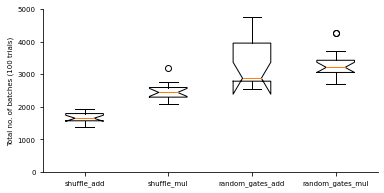

In [ ]:
fig, (ax) = plt.subplots(1,1, figsize=[6,3])
_=ax.boxplot([total_trials_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Total no. of batches (100 trials)')
ax.set_ylim([0, 5000])
# plt.savefig('./files/total_batches_box_plots.jpg',dpi=300)

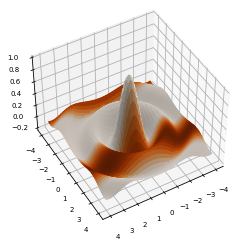

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# create some fake data
x = y = np.arange(-4.0, 4.0, 0.02)
x,y,z = gates_means, gates_stds, gates_sparsities
# here are the x,y and respective z values
X, Y = np.meshgrid(x, y)
Z = np.sinc(np.sqrt(X*X+Y*Y))
# this is the value to use for the color
V = np.sin(Y)

# create the figure, add a 3d axis, set the viewing angle
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,60)

# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
ax.plot_surface(X, Y, Z, facecolors=cm.Oranges(V))

average_acc_dict is a dict of keys experiment name. Returns a list of np arrays with accuracies from all tasks. Still need to average them [no_tasks, tstamps]


In [ ]:
def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))


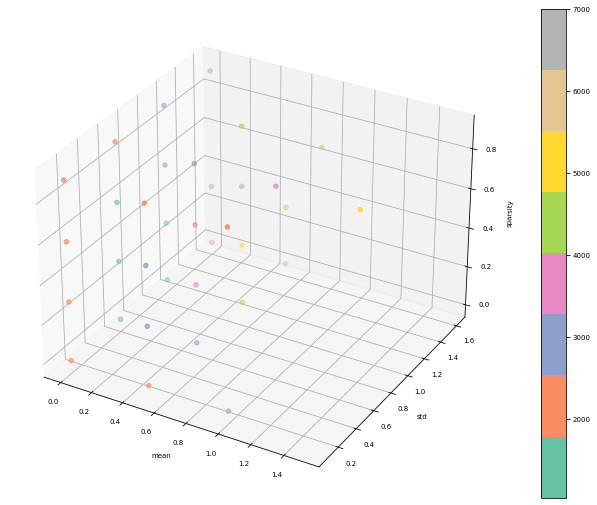

In [10]:
# Import libraries

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
# Define Dataset
x,y,z = gates_means, gates_stds, gates_sparsities

# Creating figure

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
  
# Creat color map

color_map = plt.get_cmap('Set2')
 
# Create scatter plot and colorbar

scatter_plot = ax.scatter3D(*np.meshgrid(x, y, z),
                            c=values,
                            cmap = color_map)
ax.set_xlabel('mean') ; ax.set_ylabel('std'); ax.set_zlabel('sparsity')
plt.colorbar(scatter_plot)

In [ ]:
logs, lifiles = get_log_files(folder_name, 'shuffle_add', file_sig='training_log',  search_strs=['tasks_10'])
def new_get_rehearsals(logs, rehearsal_no=1):

    # print('swtch \ttid \t rehNo \t ttc \t order')
    rehearsal_ttcs = []
    for log in logs:
        times_seen = []
        order_learned = []
        ttc = []
        np_task_id = np.array(log.switch_task_id)
        np_stamps = log.switch_trialxxbatch + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch)):
            times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
            order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
    # for i in (range(12)):
        # print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    return( np.stack(rehearsal_ttcs) )

rt = new_get_rehearsals(logs, 1)

In [ ]:
log = logs[0]
T = len(log.switch_trialxxbatch)
first_serial_block= (np.array(logs[0].trials_to_crit)> 1).argmax()
# first_serial_block= T - 8
print ('switch_trial\t task_id\t ttc\t first')
for ti in range(T-10, T):
    print (f'{log.switch_trialxxbatch[ti]}\t\t {log.switch_task_id[ti]}\t\t {log.trials_to_crit[ti]}\t', f'{1 if (first_serial_block==ti) else 0}')

switch_trial	 task_id	 ttc	 first
1298		 6		 1	 0
1299		 3		 1	 0
1299		 10		 22	 1
1321		 11		 14	 0
1335		 10		 12	 0
1347		 11		 11	 0
1358		 12		 28	 0
1386		 10		 11	 0
1397		 11		 12	 0
1409		 12		 12	 0


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


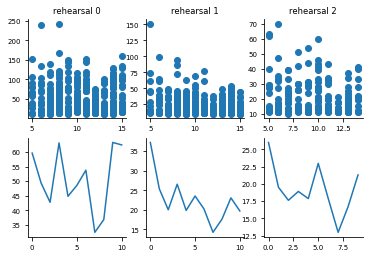

In [ ]:
exp_name = 'shuffle_add'
rehearsal_ttcs = []
global_times_seen = []
order_learned = []
ttc = []
for no_tasks in range(4,14):
    logs, lifiles = get_log_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    # print('swtch \ttid \t rehNo \t ttc \t order')
    for log in logs:
        times_seen = []
        first_serial_block= (np.array(log.trials_to_crit)> 1).argmax()
        np_task_id = np.array(log.switch_task_id[first_serial_block:])
        np_stamps = log.switch_trialxxbatch[first_serial_block:] + [log.stamps[-1]]
        for i in range(len(log.switch_trialxxbatch[first_serial_block:])):
            times_seen.append( np.sum( np_task_id[:i]== np_task_id[i]))
            order_learned.append(no_tasks+ np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        # rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
        global_times_seen += times_seen
rehearsal_no = 0
fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
fig, axes = plt.subplots(2,3)

for i in range(3):
    ax = axes[0,i]
    rehearsal_no = i
    fttc = np.array(ttc)[np.array(global_times_seen)==rehearsal_no]
    forder_learned = np.array(order_learned)[np.array(global_times_seen)==rehearsal_no]
    ax.scatter(forder_learned, fttc)
    ax.set_title(f'rehearsal {rehearsal_no}')

    ax = axes[1,i]
    ax.plot([np.mean(np.array(fttc)[np.array(forder_learned) == ol]) for ol in np.unique(forder_learned)])


#### Speared focused analysis of first learning

-8 new task  
-7 another new task2  
-6 1st rehearsal 
-5 task2 reh (1st rehearsal) 
-4 task3
-3 2nd rehearsal 
-2 task2 2nd rehearsal (2nd rehearsal) 

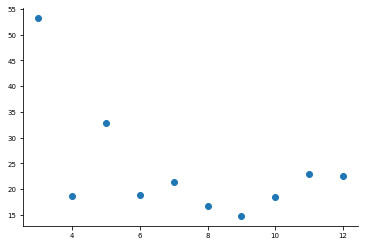

In [ ]:
ttc_pick = -1
exp_name = 'shuffle_add'
order_learned = []
ttc = []
for no_tasks in range(3,13):
    logs, lifiles = get_log_files(folder_name, exp_name, file_sig='training_log',  search_strs=[f'tasks_{no_tasks}'])
    # print('swtch \ttid \t rehNo \t ttc \t order')
    ttc_task_1 = []
    for log in logs:
        ttc_task_1.append(log.trials_to_crit[ttc_pick]) # This is the the first task learned.
    ttc.append(ttc_task_1)
    order_learned.append(no_tasks)

# fig, axes = plt.subplots(2,3)

plt.scatter(order_learned, [np.mean(tt) for tt in ttc])

